# Praca domowa 4
#### Ilona Bednarz

## Odtworzenie modelu z PD1

### Zmienna objaśniana:
S1 - Are you married?

### Wybrane zmienne objaśniające:

#### numeryczne:

* Q16: How many of your relatives do you see in person at least once a month?  - numeryczna

* pphhsize: Household Size

#### binarne:

* hcm2017q24_church: met in or through church or religious organization

* w6_otherdate_all: In past yr have you met anyone for dating romance or sex (not incl current partner)

### Zbudowany model:
RandomForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
import warnings
import waterfall_chart
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

df = pd.read_stata('dane/HCMST_2017.dta')

# wybor zmiennych
X = df[['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']].copy()
y = df['S1'].copy()

# przygotowanie danych
X['w6_otherdate_all'] = X['w6_otherdate_all'].replace('Refused', np.nan)
y = y[np.sum(X.isna(), axis=1) == 0]
X = X.dropna(axis=0).reset_index(drop=True)
bin_columns = ["hcm2017q24_church", "w6_otherdate_all"]
dummies = pd.get_dummies(X[bin_columns]).iloc[:, [1, 4]]
dummies.columns = bin_columns
X[bin_columns] = dummies
y = pd.get_dummies(y).iloc[:, 0].reset_index(drop=True) # 1 == married

# dopasowanie modelu
clf = RandomForestClassifier(n_jobs=4, n_estimators=600, random_state=123, max_depth=4)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=4,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

## Generowanie zbioru obserwacji podobnych

In [2]:
def gen_sample(obs_nr, data, N=1000, bern_prob_noise=0.2):
    obs = X.iloc[obs_nr, :]
    stds = data.std()
    new_data = pd.DataFrame()
    new_data['Q16'] = np.random.normal(obs['Q16'], stds['Q16']/2, N).astype(int)
    new_data['pphhsize'] = np.random.normal(obs['pphhsize'], stds['pphhsize']/2, N).astype(int)
    new_data['hcm2017q24_church'] = np.random.binomial(1, abs(obs['hcm2017q24_church']-bern_prob_noise), N)
    new_data['w6_otherdate_all'] = np.random.binomial(1, abs(obs['w6_otherdate_all']-bern_prob_noise), N)
    return new_data

In [3]:
osoba = 1612
print(X.iloc[osoba, :])

Q16                  12
pphhsize              2
hcm2017q24_church     0
w6_otherdate_all      1
Name: 1612, dtype: object


In [4]:
X_new = gen_sample(osoba, X, 1000)
X_new.head()

,Q16,pphhsize,hcm2017q24_church,w6_otherdate_all
0,12,2,0,1
1,8,1,1,1
2,8,0,0,1
3,14,0,0,1
4,11,2,0,1


## Predykcja na nowym zbiorze

In [5]:
pred_new = clf.predict(X_new) # prawdopodobienstwa jedynek

## Wyznaczenie wag

In [6]:
# oblicz odleglosc euklidesowa obserwacji z X_new do wybranej osoby
eukl = X_new.apply(lambda x: np.linalg.norm(x-X.iloc[osoba,:]), axis=1)

# utworz wagi - im wieksza odleglosc tym mniejsza waga
weights = eukl.max() - eukl

## Dopasowanie modelu ważonej regresji logistycznej

In [7]:
from sklearn.linear_model import SGDClassifier
lime_model = SGDClassifier(loss='log')
lime_model.fit(X_new, pred_new, sample_weight=weights)

# współczynniki modelu
print(X_new.columns.tolist())
print(lime_model.coef_) # wplyw na logarytm szansy
print(np.exp(lime_model.coef_)) # wplyw na szanse

['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']
[[  -12.51184893   353.17868862   337.4901404  -1629.03348998]]
[[3.68275690e-006 2.41855290e+153 3.71625644e+146 0.00000000e+000]]


## Interpretacja
Widzimy, że największy (co do modułu) współczynnik pojawia się przy zmiennej w6_otherdate_all, co oznacza, że ma ona bardzo silny ujemny wpływ na predykcję modelu - jeśli ktoś chodził na randki w przeciągu ostatniego miesiąca to jest małe prawdopodobieństwo, że jest w związku małżeńskim. Duży dodatni wpływ mają zmienne pphhsize oraz hcm2017q24_church - poznanie się na spotkaniu religijnym oraz mieszkanie w wieloosobowym gospodarstwie domowym powoduje stwierdzenie modelu, że osoba jest w związku małżeńskim. Zmienna Q16 (liczba członków rodziny, z którymi dana osoba utrzymuje kontakt) wydaje się być tu mało istotna. Porównajmy te spostrzeżenia z wynikami z poprzedniej pracy domowej.

## Porównanie z wynikami PD3

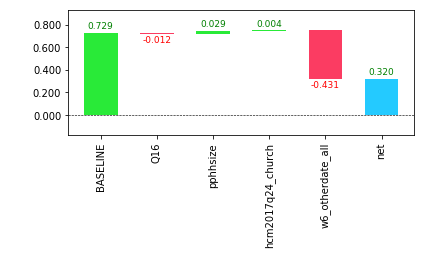

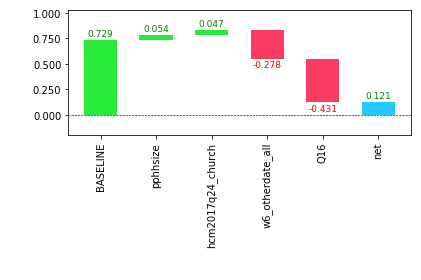

In [8]:
def plot_variable_attribution(variables, vals, model, X):
    baseline = clf.predict_proba(X)[:,1].mean()
    result = []
    newX = X.copy()
    for var, val in zip(variables, vals):
        newX = newX.loc[newX[var]==val]
        result.append(clf.predict_proba(newX)[:,1].mean()-baseline)
    variables = ['BASELINE'] + variables
    result = [baseline] + result
    waterfall_chart.plot(variables, result, formatting='{:,.3f}', rotation_value=90)
    plt.show()
plot_variable_attribution(variables=["Q16", "pphhsize", "hcm2017q24_church", "w6_otherdate_all"],
                          vals=[12, 2, 0, 1], model=clf, X=X)
plot_variable_attribution(variables=["pphhsize", "hcm2017q24_church", "w6_otherdate_all", "Q16"],
                          vals=[2, 0, 1, 12], model=clf, X=X)

## Wnioski

Wpływ zmiennej w6_otherdate_all oceniany za pomocą wykresów variable attribution jest podobny co przy metodzie LIME, czyli silnie ujemny. Natomiast istotność zmiennej Q16 zmienia się w zależności od kolejności warunkowania. Jednak przy warunkowaniu na nią na początku (pierwszy wykres) jej wpływ jest znikomy podobnie jak przy metodzie LIME. Biorąc pod uwagę obie wykorzystane metody wyjaśniania możemy stwierdzić, że samo utrzymywanie częstych kontaktów z rodziną (wysoka wartość Q16) nie świadczy o byciu lub niebyciu w związku małżeńskim, jednak przy pewnych wartościach innych zmiennych ma to już wpływ. Na przykład osoba o dużej wartości pphhsize (duże gospodarstwo domowe) może mieszkać po prostu ze swoimi rodzicami/rodzeństwem/dziadkami i z tego powodu często spotykać członków rodziny. A taka konfiguracja będzie świadczyła o tym, że ta osoba nie jest w związku małżeńskim.